In [1]:
using Pkg; Pkg.activate(".");
using Convex
using SCS

  Activating new project at `~/Dropbox (MIT)/IAP22/6.S098-project`


In [2]:
class_numbers = Dict("6.006"=>1, "6.042"=>2, "6.009"=>3, "6.046"=>4, "6.031"=>5, "18.600"=>6, "6.041"=>7,
"6.008"=>8, "comp_bio"=>9, "NLP"=>10, "comp_vision"=>11, "graphics"=>12, "optimization"=>13, 
    "script_analysis"=>14, "intro_to_acting"=>15, "psych"=>16)

taken = [1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1]

requirements = [
  ([1], 1),
  ([2], 1),
  ([3], 1),
  ([4], 1),
  ([5], 1),
  ([6, 7, 8], 1),
  ([9, 10, 11, 12, 13], 2),
  ([14, 15, 16], 2)
];

In [3]:
remaining_requirements = []

for (classes, req) in requirements
  classes_left::Array{Int64} = []
  for class in classes
    if taken[class] == 1
      req = max(req - 1, 0)
      classes_left
    else
      push!(classes_left, class)
    end
  end
  if length(classes_left) > 0
    push!(remaining_requirements, (classes_left, req))
  end
end

remaining_requirements

5-element Vector{Any}:
 ([4], 1)
 ([5], 1)
 ([7, 8], 0)
 ([9, 10, 11, 12, 13], 2)
 ([14, 15], 1)

In [4]:
class_names = Dict()
for (name, num) in class_numbers
  class_names[num] = name
end
class_names

Dict{Any, Any} with 16 entries:
  5  => "6.031"
  16 => "psych"
  12 => "graphics"
  8  => "6.008"
  1  => "6.006"
  6  => "18.600"
  11 => "comp_vision"
  9  => "comp_bio"
  14 => "script_analysis"
  3  => "6.009"
  7  => "6.041"
  13 => "optimization"
  15 => "intro_to_acting"
  4  => "6.046"
  2  => "6.042"
  10 => "NLP"

In [5]:
num_classes = length(class_names)
choices = Variable(num_classes)

Variable
size: (16, 1)
sign: real
vexity: affine
id: 803…175

In [6]:
ratings = [
  1,
  0,
  0.5,
  0.25,
  0.01,
  1,
  0,
  0,
  1,
  0.5,
  0.49,
  0,
  0,
  1,
  0,
  0
];

In [7]:
# general 1 unit per class
class_units = ones(num_classes)
obj = -1 * ratings'*choices + class_units'*choices

+ (affine; real)
├─ * (affine; real)
│  ├─ 1×16 adjoint(::Vector{Float64}) with eltype Float64
│  └─ 16-element real variable (id: 803…175)
└─ * (affine; real)
   ├─ 1×16 adjoint(::Vector{Float64}) with eltype Float64
   └─ 16-element real variable (id: 803…175)

In [8]:
# max units allowed (set arbitrarily)
max_units = sum([j for (i, j) in remaining_requirements]) + 1
min_units = 2

consts = [
  #relaxation of binary choice
  choices >= 0,
  choices <= 1,
  # max units
  sum(choices) <= max_units,
  # min units
  sum(choices) >= min_units,
]

# classes already taken cannot be taken again
for (class, done) in enumerate(taken)
  if done == 1
    consts += choices[class] == 0
  end
end

# remaining class requirements
for (classes, req) in remaining_requirements
  req_choices = sum(choices[class] for class in classes)
  consts += req_choices >= req
end

consts

14-element Vector{Constraint}:
 >= constraint (affine)
├─ 16-element real variable (id: 803…175)
└─ 0
 <= constraint (affine)
├─ 16-element real variable (id: 803…175)
└─ 1
 <= constraint (affine)
├─ sum (affine; real)
│  └─ 16-element real variable (id: 803…175)
└─ 6
 >= constraint (affine)
├─ sum (affine; real)
│  └─ 16-element real variable (id: 803…175)
└─ 2
 == constraint (affine)
├─ index (affine; real)
│  └─ 16-element real variable (id: 803…175)
└─ 0
 == constraint (affine)
├─ index (affine; real)
│  └─ 16-element real variable (id: 803…175)
└─ 0
 == constraint (affine)
├─ index (affine; real)
│  └─ 16-element real variable (id: 803…175)
└─ 0
 == constraint (affine)
├─ index (affine; real)
│  └─ 16-element real variable (id: 803…175)
└─ 0
 == constraint (affine)
├─ index (affine; real)
│  └─ 16-element real variable (id: 803…175)
└─ 0
 >= constraint (affine)
├─ index (affine; real)
│  └─ 16-element real variable (id: 803…175)
└─ 1
 >= constraint (affine)
├─ index (affine; real)

In [9]:
problem = minimize(obj, consts)
solve!(problem, SCS.Optimizer())

------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 17, constraints m: 45
cones: 	  z: primal zero / dual free vars: 6
	  l: linear vars: 39
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 93, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.04e+01  1.16e+00  2.17e+01 -9.78e+00  1.00e-01  1.08e-03 
    50| 6.33e-04  1.62e-04  3.24e-04  2.24e+00  1.00e-01  1.13e-03 
--------------------------------------

In [10]:
choices = Int.(round.(choices.value, digits=1)) + taken'

16×1 Matrix{Int64}:
 1
 1
 1
 1
 1
 1
 0
 0
 1
 1
 0
 0
 0
 1
 0
 1

In [11]:
taken_args = [i[2] for i in findall(x->x==1, taken)]
taken_names = [class_names[num] for num in taken_args]

5-element Vector{String}:
 "6.006"
 "6.042"
 "6.009"
 "18.600"
 "psych"

In [12]:
req_names = [([(class_names[i], ratings[i]) for i in classes], req) for (classes, req) in requirements]

8-element Vector{Tuple{Vector{Tuple{String, Float64}}, Int64}}:
 ([("6.006", 1.0)], 1)
 ([("6.042", 0.0)], 1)
 ([("6.009", 0.5)], 1)
 ([("6.046", 0.25)], 1)
 ([("6.031", 0.01)], 1)
 ([("18.600", 1.0), ("6.041", 0.0), ("6.008", 0.0)], 1)
 ([("comp_bio", 1.0), ("NLP", 0.5), ("comp_vision", 0.49), ("graphics", 0.0), ("optimization", 0.0)], 2)
 ([("script_analysis", 1.0), ("intro_to_acting", 0.0), ("psych", 0.0)], 2)

In [13]:
chosen = []
for (num, choice) in enumerate(choices)
  if choice == 1
    push!(chosen, class_names[num])
  end
end
chosen

10-element Vector{Any}:
 "6.006"
 "6.042"
 "6.009"
 "6.046"
 "6.031"
 "18.600"
 "comp_bio"
 "NLP"
 "script_analysis"
 "psych"

### 6-4 Class Scheduling

In [2]:
class_numbers = Dict("6.100A"=>1, "6.100L"=>2, "6.042"=>3, "18.06"=>4, "18.C06"=>5, "6.3700"=>6, "6.3800"=>7, "18.05"=>8, "6.009"=>9, "6.006"=>10, "6.3720"=>11, "6.3900"=>12, "6.3000"=>13, "6.4110"=>14, "6.4400"=>15, "6.3100"=>16, "6.7201"=>17, "6.1220" => 18, "6.3950"=>19, "6.4590"=>20, "6.4120"=>21, "6.C35"=>22, "18.404"=>23, "6.3730"=>24, "6.5151"=>25, "6.5831" => 26, "6.8701"=>27, "6.4200"=>28, "6.4860"=>29, "6.8301"=>30, "6.8611"=>31, "6.8371"=>32, "6.1800"=>33, "6.4210"=>34, "8.01"=>35, "8.02"=>36, "18.01"=>37, "18.02"=>38, "7.012" =>39, "3.091"=>40);

In [3]:
requirements = [([1, 2], 1), ([3], 1), ([4, 5], 1), ([6, 7, 8], 1), ([9], 1), ([10], 1), ([11, 12], 1), ([13, 14, 15], 1), ( [16, 14, 17], 1), ([18, 17, 15], 1), ([13, 14, 15], 1), ([19, 20, 21, 22], 1), ([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 5), ([23, 24, 25, 26, 27, 32], 2), ([28, 29, 30, 31, 33, 34], 1), ([35, 36 ,37, 38, 39, 40], 6)];

In [4]:
ratings = [(0.01674107358514243, "6.4400"), (0.20625928189455645, "6.8371"), (0.22411918043819912, "6.1800"), (0.3720293803566581, "6.4860"), (1.1037562563817414, "6.5151"), (1.1391108491597546, "6.100A"), (1.2440241764393214, "6.5831"), (1.3927481839669749, "6.100L"), (1.8166770823918532, "18.02"), (2.130709542446836, "7.012"), (2.3487402422339105, "6.7201"), (2.473889451047344, "6.4210"), (2.614809345119018, "6.3000"), (2.64619846706188, "6.3800"), (2.7072060642300233, "6.4590"), (2.776022604987598, "6.4120"), (2.976904834376327, "6.3700"), (3.2668225160548845, "8.02"), (3.2994078409056566, "6.8701"), (3.3831403878557094, "6.8611"), (3.5814077129516733, "6.1220"), (3.770363367737921, "6.3950"), (4.003959870502843, "6.8301"), (4.434791516169647, "6.3100"), (4.541245269717419, "6.C35"), (4.802106023194701, "6.3730"), (5.173419086011188, "8.01"), (5.470904504057465, "6.042"), (5.488696411402272, "18.06"), (5.821081979940469, "6.009"), (5.884020141684222, "6.4110"), (6.0349305282232795, "18.C06"), (6.209625795839438, "6.006"), (6.296384800653085, "18.05"), (6.321692746061686, "6.3900"), (6.336657643960599, "18.404"), (6.534235424395592, "6.3720"), (6.776456731707294, "18.01"), (6.883832570062196, "6.4200"), (6.996415633409068, "3.091")];

In [5]:
times = [ (7.134249394233765, "6.5831"), (7.396059338516257, "6.4200"), (7.453847077624196, "6.4400"), (7.566455957170015, "6.100A"), (7.629599059188994, "6.4860"), (7.720090482611781, "6.3720"), (7.9027807886952015, "6.042"), (7.988289786870112, "6.8301"), (8.063216782709574, "6.1220"), (8.360355423630764, "6.5151"), (8.361240238143546, "6.7201"), (8.488635039417355, "18.06"), (8.541341885245481, "6.3900"), (8.724423998523866, "6.4210"), (9.286618824654433, "6.3000"), (9.395426143424102, "6.3800"), (9.79495084702973, "6.1800"), (9.826000265111922, "6.4110"), (9.925436963128544, "6.006"), (9.972179587490789, "6.009"), (10.046789284566916, "6.C35"), (10.340590565214246, "18.05"), (10.732325505245441, "3.091"), (11.311122268822817, "6.3700"), (11.433944186599682, "18.01"), (11.554575740671433, "7.012"), (11.55574881456855, "6.4590"), (11.794572657409711, "8.02"), (11.839478356831748, "18.02"), (12.028994228824299, "6.8611"), (12.571159178011918, "6.8371"), (12.575191723569695, "18.C06"), (12.950073111878748, "6.3730"), (12.952488499710569, "6.3950"), (13.101491873044838, "18.404"), (13.206054155678526, "6.3100"), (13.54352553482211,"6.4120"), (13.736593326114928,"6.8701"), (13.778108052922672, "8.01"), (13.814044135950908, "6.100L")];

In [6]:
class_names = Dict()
for (name, number) in class_numbers
  class_names[number] = name
end

In [7]:
ratings_dict = Dict()
for (rating, class_name) in ratings
  ratings_dict[class_numbers[class_name]] = rating
end
ratings_vec = []
for i in 1:length(ratings_dict)
  push!(ratings_vec, ratings_dict[i])
end

In [8]:
times_dict = Dict()
for (time, class_name) in times
  times_dict[class_numbers[class_name]] = time
end
times_vec = []
for i in 1:length(class_numbers)
  push!(times_vec, times_dict[i])
end

In [88]:
function schedule_optimizer(taken, mu)
  n = length(class_numbers)
  choices = Variable(n) 

  remaining_requirements = []
  for (classes, req) in requirements
    classes_left::Array{Int64} = []
    for class in classes
      if taken[class] == 1
        req = max(req - 1, 0)
        classes_left
      else
        push!(classes_left, class)
      end
    end
    if length(classes_left) > 0
      push!(remaining_requirements, (classes_left, req))
    end
  end

  average_hours = sum(times_vec) / length(times_vec)
  max_hours = 8 * 5 * average_hours
  min_hours = 2 * average_hours

  total_hours = sum([times_vec[i] * choices[i] for i in 1:n])
  
  consts = [
    #relaxation of binary choice
    choices >= 0,
    choices <= 1,
    # max units
    total_hours <= max_hours,
    # min units
    total_hours >= min_hours
  ]

  # classes already taken cannot be taken again
  for (class, done) in enumerate(taken)
    if done == 1
      consts += choices[class] == 0
    end
  end

  # remaining class requirements
  for (classes, req) in remaining_requirements
    req_choices = sum(choices[class] for class in classes)
    consts += req_choices >= req
  end

  obj = -1 * sum([ratings_vec[i]*choices[i] for i in 1:n]) + mu * times_vec'*choices
  
  problem = minimize(obj, consts)
  solve!(problem, SCS.Optimizer())

  schedule = Int.(round.(choices.value, digits=1))
  total_time = round((times_vec'*schedule)[1], digits=1)
  schedule_rating = round((ratings_vec'*schedule / sum(schedule))[1], digits=3)

  chosen = []
  for (num, choice) in enumerate(schedule)
    if choice == 1
      push!(chosen, class_names[num])
    end
  end

  print("Classes: $chosen\n")
  print("Total time: $total_time hours\n")
  print("Rating: $schedule_rating / 7.0\n")

  return schedule_rating, total_time
end

------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 41, constraints m: 99
cones: 	  z: primal zero / dual free vars: 1
	  l: linear vars: 98
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 259, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 4.14e+02  1.17e+01  4.34e+02 -2.43e+02  1.00e-01  1.54e-04 
   150| 4.13e-03  2.83e-05  1.24e-03 -1.50e+02  1.10e-02  5.53e-04 
-------------------------------------

schedule_optimizer (generic function with 1 method)

In [89]:
n = length(class_numbers)
schedule_optimizer(zeros(n), 10)

Classes: Any["6.100A", "6.042", "18.06", "6.3800", "6.009", "6.006", "6.3720", "6.4400", "6.7201", "6.1220", "6.C35", "6.5151", "6.5831", "6.4200", "8.01", "8.02", "18.01", "18.02", "7.012", "3.091"]
Total time: 188.9 hours
Rating: 3.96 / 7.0
------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 41, constraints m: 99
cones: 	  z: primal zero / dual free vars: 1
	  l: linear vars: 98
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 259, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (

(3.96, 188.9)

In [143]:
avg_ratings = []
avg_times = []
mu_min = 0
mu_max = 10
mu_range = mu_min:0.1:mu_max
for i in mu_range
  r, t = schedule_optimizer(zeros(n), i)
  push!(avg_ratings, r)
  push!(avg_times, t)
end

In [144]:
Pkg.add("Plots"); using Plots;

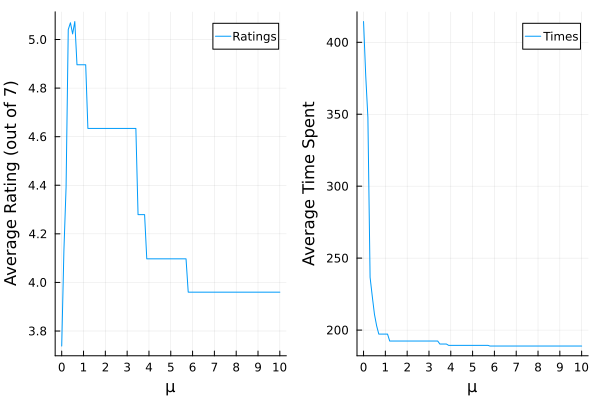

In [146]:
ar = plot(mu_range, avg_ratings, xticks=mu_min:1:mu_max, label="Ratings", ylabel="Average Rating (out of 7)")
at = plot(mu_range, avg_times, xticks=mu_min:1:mu_max, label="Times", ylabel="Average Time Spent")
plot(ar, at, layout=(1, 2), xlabel="μ")